In [35]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [36]:
import xml.etree.ElementTree as ET
from pathlib import Path

In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import numpy as np
import re
from pytesseract import Output

In [38]:
from keras.models import load_model
import pytesseract
import cv2
from google.colab.patches import cv2_imshow

In [39]:
def create_mask(pred_mask1, pred_mask2):
  

  """Return a filter mask with the top 1 predictions
    only.

  """

  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = tf.expand_dims(pred_mask1, axis=-1)
    
  pred_mask2 = tf.argmax(pred_mask2, axis=-1)
  pred_mask2 = tf.expand_dims(pred_mask2, axis=-1)
  return pred_mask1[0], pred_mask2[0]

In [40]:
def load_img(path):
  test_image = Image.open(path)
  test_data = tf.data.Dataset.list_files(path)
  #size = len(list(test_data))
  size = int(len(list(test_data)))
  BATCH_SIZE = 1
  test=test_data.take(size)
  test = test.map(parse_image)
  test_dataset = test.batch(BATCH_SIZE)

  return test_dataset

In [7]:
def parse_image(img_path):
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image =tf.image.resize(image, [1024, 1024])
    image = tf.cast(image, tf.float32) / 255.0
    #image = tf.image.convert_image_dtype(image, tf.uint8)

    # For one Image path:
    # /content/drive/MyDrive/Marmot_data.zip/images/10.1.1.1.2006_3.jpeg
    # Its corresponding table mask path is:
    #  /content/drive/MyDrive/Marmot_data.zip/table_mask/10.1.1.1.2006_3.jpeg
    # Its corresponding column mask path is:
    #  /content/drive/MyDrive/Marmot_data.zip/column_mask/10.1.1.1.2006_3.jpeg

    table_mask_path = tf.strings.regex_replace(img_path, "images", "table_mask")
    table_mask = tf.io.read_file(table_mask_path)

    # The masks contain a class index for each pixels
    table_mask = tf.image.decode_jpeg(table_mask, channels=1)
    table_mask =tf.image.resize(table_mask, [1024, 1024])
    table_mask = tf.cast(table_mask, tf.float32) / 255.0


    column_mask_path = tf.strings.regex_replace(img_path, "images", "column_mask")
    column_mask = tf.io.read_file(column_mask_path)

    # The masks contain a class index for each pixels
    column_mask = tf.image.decode_jpeg(column_mask, channels=1)
    column_mask =tf.image.resize(column_mask, [1024, 1024])
    column_mask = tf.cast(column_mask, tf.float32) / 255.0


  
    return image, {'table_mask':table_mask,'column_mask':column_mask}

In [41]:
def show_predictions(dataset=None, num=1):
  """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
  if dataset:

      for image, (mask1, mask2) in dataset.take(num):
            
          pred_mask1, pred_mask2 = model1.predict(image, verbose=1)
          table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
          display([image[0], table_mask, column_mask])
  else:
      pred_mask1, pred_mask2 = model1.predict(sample_image, verbose=1)
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)

      display([sample_image[0], table_mask, column_mask])

In [42]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
      reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
      i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [288]:
def extract_info(file):
  img = cv2.imread(file,0)
  #thresholding the image to a binary image
  thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
  img_bin = 255-img_bin
  cv2.imwrite('/content/drive/MyDrive/MARMOT/cv_inverted.png',img_bin)
  # Length(width) of kernel as 100th of total width
  kernel_len = np.array(img).shape[1]//100
  # Defining a vertical kernel to detect all vertical lines of image 
  ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
  # Defining a horizontal kernel to detect all horizontal lines of image
  hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
  # A kernel of 2x2
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
  image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
  vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
  cv2.imwrite("/Users/YOURPATH/vertical.jpg",vertical_lines)
  image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
  horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
  cv2.imwrite("/Users/YOURPATH/horizontal.jpg",horizontal_lines)

  # Combine horizontal and vertical lines in a new third image, with both having same weight.
  img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
  #Eroding and thesholding the image
  img_vh = cv2.erode(~img_vh, kernel, iterations=2)
  thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  cv2.imwrite("/Users/YOURPATH/img_vh.jpg", img_vh)
  bitxor = cv2.bitwise_xor(img,img_vh)
  bitnot = cv2.bitwise_not(bitxor)

  # Detect contours for following box detection
  contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

  #Creating a list of heights for all detected boxes
  heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
  #Get mean of heights
  mean = np.mean(heights)

  #  Create list box to store all boxes in  
  box = []
  # Get position (x,y), width and height for every contour and show the contour on image
  for c in contours:
      x, y, w, h = cv2.boundingRect(c)
      if (w<1000 and h<500):
          image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
          box.append([x,y,w,h])

  rows=[]
  columns=[]
  heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
  mean = np.mean(heights)
  #print(mean)
  columns.append(box[0])
  previous=box[0]
  for i in range(1,len(box)):
      if(box[i][1]<=previous[1]+mean/2):
          columns.append(box[i])
          previous=box[i]
          if(i==len(box)-1):
              rows.append(columns)
      else:
          rows.append(columns)
          columns=[]
          previous = box[i]
          columns.append(box[i])

  row=[]
  column=[]
  j=0
  #Sorting the boxes to their respective row and column
  for i in range(len(box)):
      if(i==0):
          column.append(box[i])
          previous=box[i]
      else:
          if(box[i][1]<=previous[1]+mean/2):
              column.append(box[i])
              previous=box[i]
              if(i==len(box)-1):
                  row.append(column)
          else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])

   #calculating maximum number of cells
  countcol = 0
  for i in range(len(row)):
      countcol = len(row[i])
      if countcol > countcol:
          countcol = countcol           

    
  #Retrieving the center of each column
  center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
  center=np.array(center)
  center.sort()

  #Regarding the distance to the columns center, the boxes are arranged in respective order
  finalboxes = []
  for i in range(len(row)):
      lis=[]
      for k in range(countcol):
          lis.append([])
      for j in range(len(row[i])):
          diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
          minimum = min(diff)
          indexing = list(diff).index(minimum)
          lis[indexing].append(row[i][j])
      finalboxes.append(lis)

  outer=[]
  for i in range(len(finalboxes)):
      for j in range(len(finalboxes[i])):
          inner=""
          if(len(finalboxes[i][j])==0):
              outer.append(' ')
          else:
              for k in range(len(finalboxes[i][j])):
                  y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                  finalimg = bitnot[x:x+h, y:y+w]
                  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                  border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                  resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                  dilation = cv2.dilate(resizing, kernel,iterations=1)
                  erosion = cv2.erode(dilation, kernel,iterations=1)

                
                  out = pytesseract.image_to_string(erosion)
                  out=re.sub("\n","",out)
                  if(len(out)==0):
                      out = pytesseract.image_to_string(erosion, config='--psm 3')
                  inner = inner +" "+ out
              outer.append(inner)    
    
  #Creating a dataframe of the generated OCR list
  arr = np.array(outer)
  dataframe = pd.DataFrame(arr.reshape(len(row),countcol))

  #data.to_excel("/content/drive/MyDrive/MARMOT/output.xlsx")
  #dataframe.to_csv('/content/drive/MyDrive/MARMOT/file_test.csv')


  return dataframe

#Pipeline

In [290]:
def extract_text(path):
  model1 = load_model('/content/drive/MyDrive/MARMOT/model_Tablenet/')
  test_image  = cv2.imread(path)# load image

  test_dataset = load_img(path)
  for image, (mask1, mask2) in test_dataset:
    pred_mask1, pred_mask2 = model1.predict(image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)

  img_mask = tf.keras.preprocessing.image.array_to_img(table_mask)  

  #img_array = table_mask #array for the img_mask

  img_array = np.array(img_mask)

  fin = cv2.bitwise_and(test_image , test_image , mask = img_array)
  fin[img_array==0] = 255

  cv2.imwrite("/content/drive/MyDrive/MARMOT/appimage1.jpeg", fin)
  

  #image_path_in_colab="/content/drive/MyDrive/MARMOT/appimage.png"
  #extractedInformation = pytesseract.image_to_string(Image.open(image_path_in_colab))
  #extractedInformation=extractedInformation.strip()
  #extractedInformation=re.sub("\n","",extractedInformation)
  data = extract_info("/content/drive/MyDrive/MARMOT/appimage1.jpeg")

  data.to_csv('/content/drive/MyDrive/MARMOT/file_test.csv')

  #create_csv(extractedInformation)

  #img = Image.open("/content/drive/MyDrive/MARMOT/appimage.png")
  
  return data



## **Test with three images**

# *Image 1*

In [293]:
text = extract_text("/content/drive/MyDrive/MARMOT/images/10.1.1.1.2019_3.jpeg")

1/1 [==============================] - 10s 10s/step


In [292]:
text

,0,1,2,3
0,Proximate objectiveUltimate objectiveModel of...,Macroprudential limit financial system-wide ...,,
1,,in terms of system-wide distress;top-down,,


In [294]:
img = Image.open("/content/drive/MyDrive/MARMOT/appimage1.jpeg")

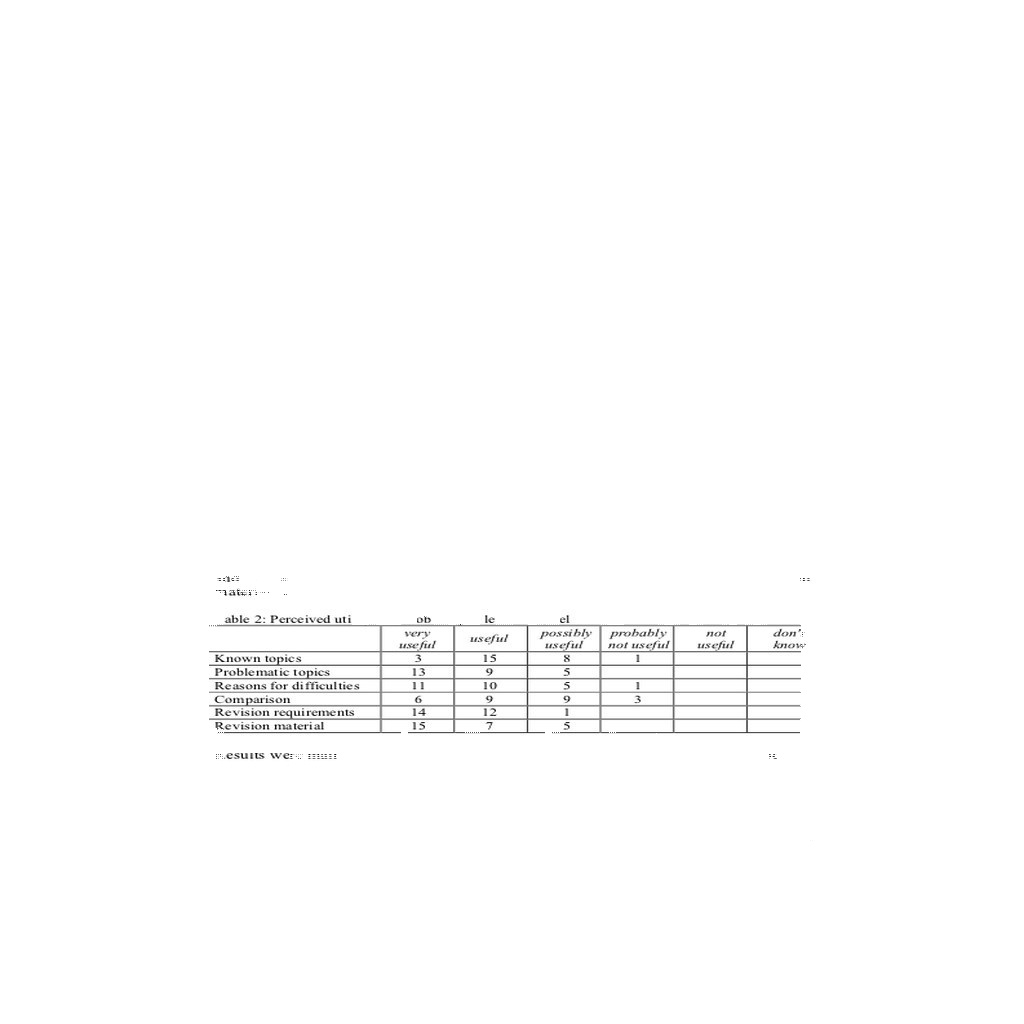

In [295]:
img

## *Image 2*

In [305]:
text = extract_text("/content/drive/MyDrive/MARMOT/images/10.1.1.1.2024_3.jpeg")

1/1 [==============================] - 11s 11s/step


In [306]:
text

,0,1,2,3,4
0,,noun/verb,"noun, absolutefreequency","verb, absolutefrequency",
1,,mistrust/mistrust life/live promise/promise...,107 2358 69 195,700 38 330,
2,,,,,


In [298]:
img = Image.open("/content/drive/MyDrive/MARMOT/appimage1.jpeg")

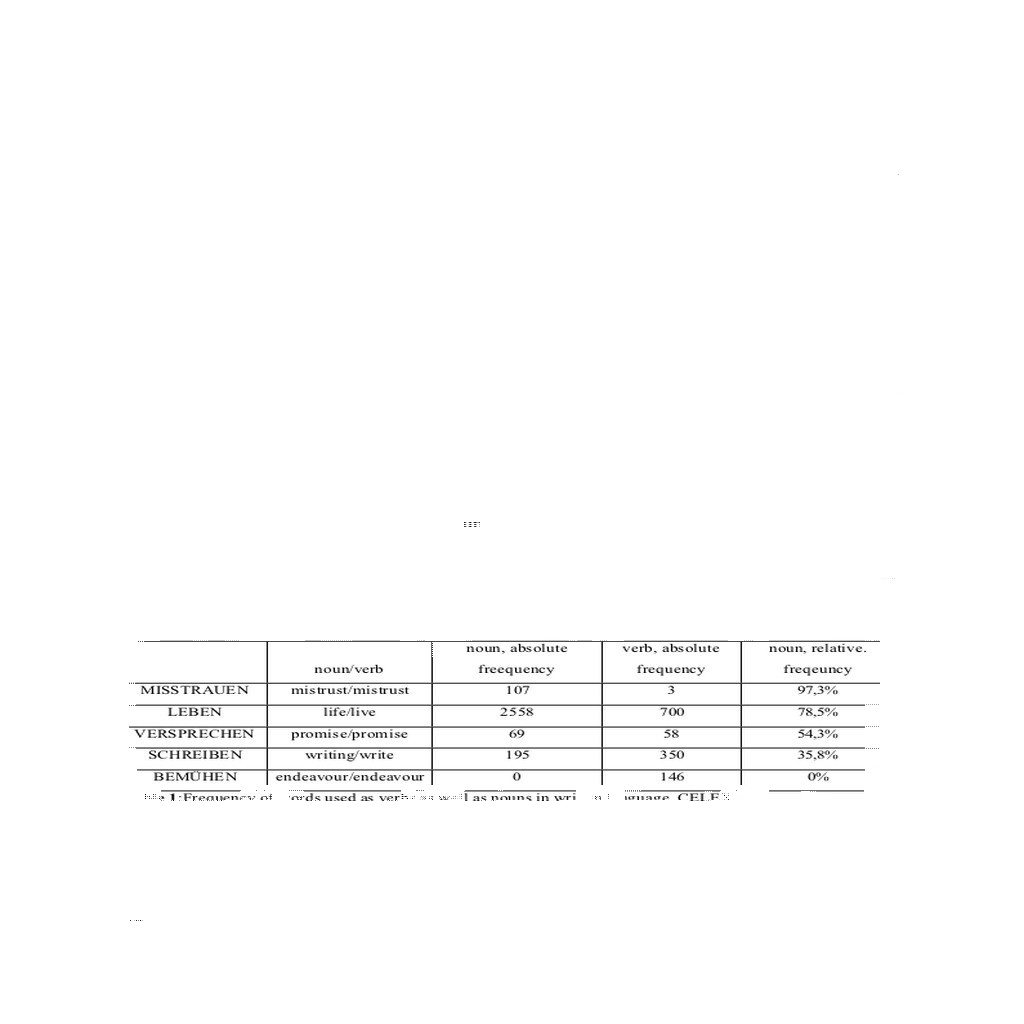

In [299]:
img

## *Image 3*

In [300]:
text = extract_text("/content/drive/MyDrive/MARMOT/images/10.1.1.34.7043_72.jpeg")

1/1 [==============================] - 10s 10s/step


In [301]:
text

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Computerizedn=21Pre-computer MIACS in c...,,,,,,,,,,,,
1,,43.7 95.3 76.0 19.3 42 17.9,,,,,,,,,,,


In [302]:
img = Image.open("/content/drive/MyDrive/MARMOT/appimage1.jpeg")

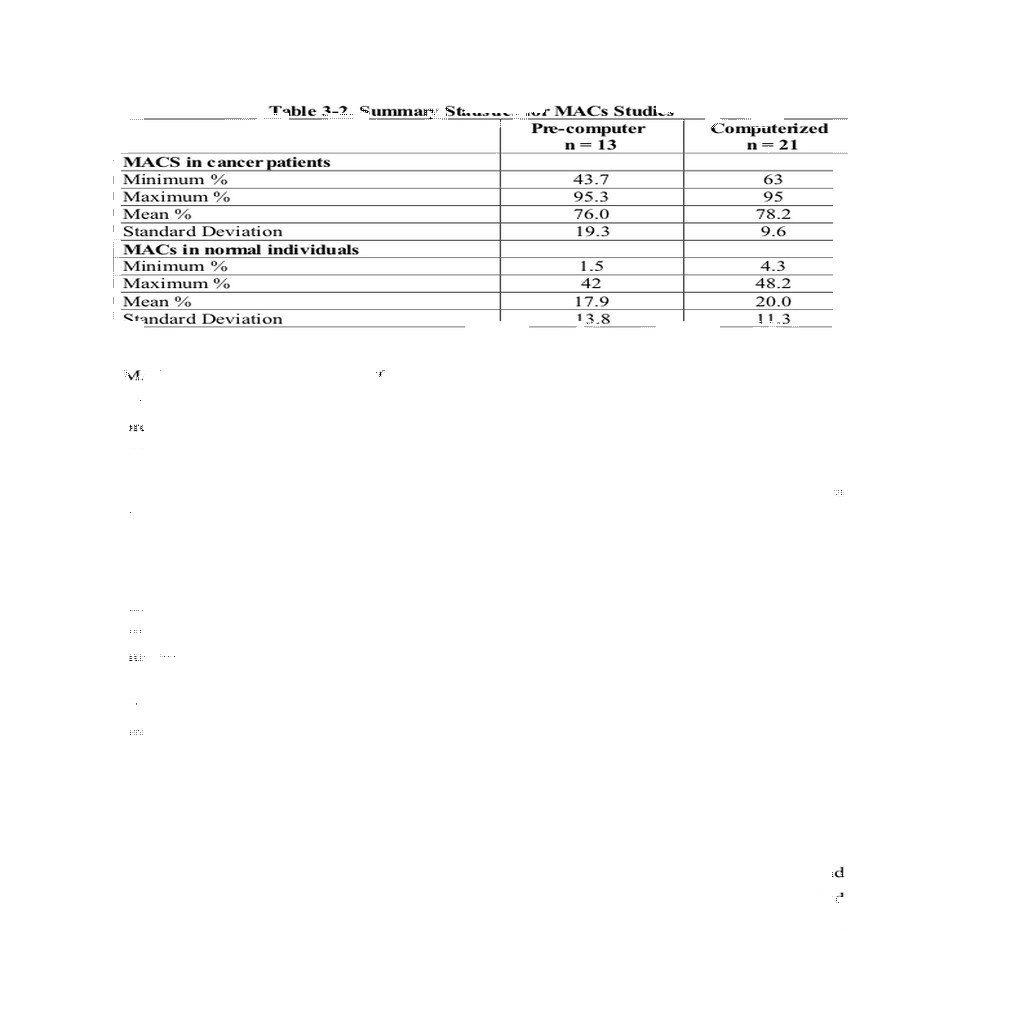

In [303]:
img